# Week 7- Accounting for Context (Deep Learning & Transformers)

In this week we introduce the use of Deep Neural Networks to work with text. These models make use of word embeddings to learn complex semantic and syntactic relations. We focus on BERT, which is a language model built using bidirectional encoders. It allows us to take advantage of a powerful pre-trained model which we can then use to perform our own tasks based on data we analyze.

In this notebook we use ```huggingface/transformers```, a Python package that allows for easy interface to use pre-trained BERT models. It is built using Tensorflow and PyTorch, two computational graph packages which are built specifically for creating powerful neural networks. We will also be introducing Keras, which allows us to easily build Neural Networks in an abstracted way. Keras is a popular way to understand how we can stack layers to create such Neural Networks, but to reach state-of-the-art results we will stick with using BERT and similar models that can be tuned to extremely high performance on specific language understanding and generation tasks.

To demonstrate this, we begin by using the [Corpus of Linguistic Acceptability](https://nyu-mll.github.io/CoLA/). We will also use BERT by learning how to extract embeddings from such a model and use it to semantically probe sentences.

## NOTE

This notebook **requires** GPUs for training models in section 1 and section 3. To train models, please use [the Google Colab version of this notebook](https://colab.research.google.com/drive/1gOsnNHdFQmRXSQyZkkROeuydPoWu_JzO) to create the models, unless you have a suitable GPU and software to do it on your local machine.

If you run the computationally intensive models on a CPU, they will take a long time!

Also, while this is one of the longer assignments, much of the Jupyter Notebook is neural network code that you can read through quickly.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

     |████████████████████████████████| 3.5 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 58.2 MB/s 
     |████████████████████████████████| 596 kB 62.9 MB/s 
     |████████████████████████████████| 6.8 MB 62.0 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-x7uo99_h
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-x7uo99_h
     |████████████████████████████████| 5.6 MB 4.2 MB/s 
     |████████████████████████████████| 117 kB 80.8 MB/s 
     |████████████████████████████████| 181 kB 86.7 MB/s 
     |████████████████████████████████| 76 kB 7.3 MB/s 
     |████████████████████████████████| 132 kB 65.8 MB/s 
     |█████████████████████████

In [3]:
%matplotlib inline

In [4]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [5]:
cd /content/drive/My Drive

/content/drive/My Drive


## CoLA Dataset and pre-processing

We start with loading our dataset and pre-processing it. The pre-processing follows similar steps as we have done in the past, but we will be using pre-written modules offered by the transformers package. These are some of the things we have to take care of when using this particular BERT model.

    -special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])
    -tokens that conforms with the fixed vocabulary used in BERT
    -token IDs from BERT’s tokenizer
    -mask IDs to indicate which elements in the sequence are tokens and which are padding elements
    -segment IDs used to distinguish different sentences
    -positional embeddings used to show token position within the sequence


We will be using parts of the code from [this notebook](https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=BJR6t_gCQe_x) which walks us through the process of using a pre-trained BERT model. The interface to use these models comes from the package [huggingface/transformers](https://github.com/huggingface/transformers). 

We start by setting up our GPU if we can - this may not work on your machine, so it has been commented out.

An aside: check out this tutorial too - https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [6]:
gpu = torch.cuda.is_available()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu:
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [8]:
device

device(type='cuda')

In [ ]:
df = pd.read_csv("../data/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [ ]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

### Introducing Deep Neural Nets with Keras LSTM

A popular, simplified package for introducing deep neural networks is [Keras](https://keras.io). It is a high level package in that we don't bother with every detail or hyper-parameter associated with the neural network (e.g., regularizers), and can stack on layers directly. For a rapid tutorial on neural networks for text such as the LSTM or the Recurrent Neural Network, Colah's blog is a great start. [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is an article on LSTMs, and if you'd like to  learn about RNN, Andrej Karpathy does a great job in [this blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), in addition to our reading from the newest online verion of Jurafsky & Martin's review of deep learning methods in their book on speech and language processing, chapters [6,7,9,10](https://web.stanford.edu/~jurafsky/slp3/), and the [*Deep Learning*](https://www.deeplearningbook.org/) book by Goodfellow, Bengio & Courville.

Before we get to BERT, in the following cells we build a basic deep net that has an embedding layer and an LSTM to perform classification. This is to illustrate the process of using Keras, which is a very popular library for such work. It may not yield state of the art performance because it constrains the hyperparameters you can tune, but is nonetheless an useful tool and works well on some datasets.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [ ]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

In [ ]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

We can see that the accuracy of this model isn't terrible, but it still hovers around 70%. Below there is code for a slightly modified neural network - how does this one perform? Note that in this model, I have added another LSTM layer. You are encouraged to explore the [Keras documentaion](https://keras.io/layers/about-keras-layers/) to explore what kind of layers you can add and how they change performances for different tasks. Different kinds of losses, optimizers, activations and layers can change the flavour of your net dramatically.

In [ ]:
# model_lstm2 = Sequential()
# model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
# model_lstm2.add(LSTM(units))
# model_lstm2.add(LSTM(units))
# model_lstm2.add(Dense(1, activation='sigmoid'))
# model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# history_lstm2 = model_lstm2.fit(input_data_train, labels, epochs=10, batch_size=batch_size)

# Encoders, Decoders, Seq2Seq and Attention
An important part of transformers are the Encoder and Decoder models, which are a powerful way to deal with sequence to sequence problems - this kind of setup is also called seq2seq.

When we use this kind of sequence to sequence alignment and also map certain parts of the sequences with different values (a process called Attention), the sequence to sequence prediction task performance increases. In this section and the next we will focus on Machine Translation as the domain to try Encoder and Decoder tasks, without and then with attention. 

**We highly recommend using this [visual blog](http://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) which explains seq2seq and attention based models**

We will be using the code from a Keras tutorial and PyTorch tutorial to demonstrate these models.

## Character-level recurrent sequence-to-sequence model

This code is adapted from the [Keras official tutorial](https://keras.io/examples/nlp/lstm_seq2seq/) on seq2seq using LSTM, authored by [fchollet](https://twitter.com/fchollet). 

### Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


### Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

### Download the data


In [ ]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

### Configuration


In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"

### Prepare the data


In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


### Build the model


In [ ]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


### Train the model


In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")


### Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



You can now generate decoded sentences as such:


In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)



##  Translation with a Sequence to Sequence Network and Attention

This code is adapted from the [PyTorch official tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), authored by [Sean Robertson](https://github.com/spro/practical-pytorch).




### Introduction
In this project we will be teaching a neural network to translate from
French to English.


    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.


To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

### imports

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading data files


The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

### The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.






In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)



### Training

Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Training and Evaluating

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

### Visualizing Attention


A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# Transformers

Transformers are a neural architecture comprised of encoder component and a decoder component, which use self-attention to reach high levels of performance for sequence to sequence tasks (and drops all RNN components!)

**We highly recommend reading this [visual blog](http://jalammar.github.io/illustrated-transformer/) on the Transformer before proceeding.**


## Models

We usually see two families of models - the Generative Pre-Trained Transformer models (GPT-n) developed by Open-AI, and the BERT family of models developed by Google, which featured Bi-directional Transformers as language models.

### GPT and similar models

These are auto-regressive language models created by [OpenAI](https://openai.com/). GPT3 has 175 billion parameters and is one of the largest, most powerful generative language model available today.

**We highly recommend reading this [visual blog](http://jalammar.github.io/illustrated-gpt2/) on the GPT-2 before proceeding.**


### BERT and similar models

The BERT model, first presented by Google Research, uses bi-directional transformers and two tasks - Masked Language Modelling task, and Next Sentence Prediction task, to train the model. These large transformers based models are trained on lots of data (Wikipedia + books). BERT has since spun off many models, include language specific ones (SpanBERT), domain specific models (SciBERT), and different level of sequences (CharacterBERT). 

**We highly recommend reading this [visual blog](http://jalammar.github.io/illustrated-bert/) on BERT and similar models before proceeding**.

Since BERT, the state of the art has constatly been beat by models such as XL-Net. We recommend this [blog post](https://medium.com/@phylypo/a-survey-of-the-state-of-the-art-language-models-up-to-early-2020-aba824302c6) which describes various language models as of 2020 (right before GPT-3 burst on the scene). 

We also highly recommend these papers for a more critical view on such language models:

[On the Dangers of Stochastic Parrots: Can Language Models Be Too Big? 🦜](https://dl.acm.org/doi/10.1145/3442188.3445922) - Bender et al, 2021

[Climbing towards NLU: On Meaning, Form, and Understanding in the Age of Data](https://www.aclweb.org/anthology/2020.acl-main.463/) - Bender and Koller, 2020


### On with BERT!

So while Neural Networks can do a good job with some kind of classification tasks, they don't perform too well on intent classification. Let us see how a bidirectional transformer embedding like BERT might do. 

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Loading our Models

### Train Model
Now that our input data is properly formatted, it's time to fine tune the BERT model.
For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.
We'll load BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

### Structure of Fine-Tuning Model

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.

### The Fine-Tuning Process

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.
Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

Credit to Michel Kana's [tutorial](https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03) and the [tutorial](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=GuE5BqICAne2) by Chris McCormick and Nick Ryan who describe the workings of BERT and the way it is used by the ```transformers``` package. 

## WARNING: SHIFT TO A GPU ENABLED MACHINE (e.g., Google Colab)

Note that you only want to run the following code if you have a GPU. Otherwise, rerun the **same** cells we just ran on the Colab file to train your model, download it to your local, and load it by running
```model = BertForSequenceClassification.from_pretrained("my_model_directory", num_labels=2)```.


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

In [ ]:
model

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [9]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [10]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Note that the following cell can take 12 hours or longer if run without a GPU.

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## COME BACK TO THIS NOTEBOOK if you are using a non-GPU machine to load and work with your GPU-trained model

Once you tune your model on Colab (or on your own machine if you decided to do that instead), you load it here.

In [ ]:
model = BertForSequenceClassification.from_pretrained("model_save", num_labels=2)

### Holdout Set

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("../data/cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

In [ ]:
matthews_set

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

That's pretty good performance. Note that we used [Matthews Correlation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) to meausure this. It ranges from -1 to 1, with +1 being the best. The Google BERT model has a similar score too, so this model performed quite well. It took a long time though, approximately a day with no GPU. It would be significantly faster if a CUDA enabled machine ran this. Hence, we recommend that you run this on the Collab notebook.

The following lines save the model to disk, if you would like to: note that we ran this in the colab file to save it to disk there as well.

In [ ]:
# import os

# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = './model_save/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that estimate a deep classification model with LSTM, seq2seq, and BERT in order to predict pre-established data labels relevant to your final project. Which works better? Are the errors the same or different?

<font color="red">***Stretch***</font>: <font color="red">Now alter the neural network by stacking network layers, adjusting the embedding dimension, compare its performance with your model above, and interpret why it might be different.

In this exercise, I use movie reviews' contents and ratings to predict some users' preferences who left comments but didn't leave rating socres. The results could be used to recommend movies to users according to their historical movie comments even if they don't rate the movies. 

##Preprocessing

In [ ]:
comments = pd.read_csv('/content/drive/MyDrive/Dataset/moviedata_small/comments.csv')
comments = comments.loc[:, ['comment_time','douban_id', 'rating', 'content']]
# comments = pd.read_csv('/content/drive/MyDrive/Dataset/moviedata-10m/comments.csv')
# comments = comments.loc[:, ['COMMENT_TIME','MOVIE_ID', 'RATING', 'CONTENT']]
comments

,comment_time,douban_id,rating,content
0,2018-09-05 19:42:07,5113101,2.0,480p，画质不高，黑白，y
1,2019-07-09 14:52:07,5113101,1.0,毫无看点，黑白画质，一个男人孤独的心理情景历程，疯疯癫癫，没有任何恐怖的成分，这应该是剧情片吧.
2,2010-11-05 22:15:44,3718526,3.0,上吊那裡超好笑，可惜最後報告近況的旁白大扣分
3,2010-06-20 02:12:50,3718526,NaN,上海国际电影节观摩片
4,2011-04-09 22:10:13,3718526,NaN,！
...,...,...,...,...
4995,2010-09-11 13:46:02,1309050,5.0,搞笑的励志电影
4996,2010-10-23 13:19:17,1309050,3.0,美国所谓的人权
4997,2009-01-22 18:36:13,1309050,3.0,2009.1.21在书房跟老公一起看的。没看完，但看过的部分很精彩。期待……
4998,2011-10-19 12:00:27,1309050,3.0,我喜欢亚当桑德勒说，橄榄球跟乒乓球差不多，就是是蛋形的，跟我的头一样 lol!! 另外，我的...


In [ ]:
from collections import Counter
rating_count = dict(Counter(comments['rating']))
rate_1 = rating_count[1.0]
rate_2 = rating_count[2.0]
rate_3 = rating_count[3.0]
rate_4 = rating_count[4.0]
rate_5 = rating_count[5.0]
rate_nan = len(comments) - rate_1 - rate_2 - rate_3 - rate_4 - rate_5
print("rating_count:\n rate1.0: {}\n rate2.0: {}\n rate3.0: {}\n rate4.0: {}\n rate5.0: {}\n rate nan: {}"
.format(rate_1,rate_2,rate_3,rate_4,rate_5,rate_nan))

rating_count:
 rate1.0: 310
 rate2.0: 533
 rate3.0: 1436
 rate4.0: 1492
 rate5.0: 871
 rate nan: 358


The goal of the recommendation system is to recommend movies that users may like, but not movies they dislike. So it is not a must-do thing to predict the accurate socres users may rate. Here we define user likes a movie if they rate 4.0 or 5.0, dislikes a movie if they rate 1.0, 2.0, or 3.0. 

In [ ]:
def get_labels(x):
  if x in set((1.0, 2.0, 3.0)):
    return 0
  elif x in set((4.0, 5.0)):
    return 1 
  else:
    return -1

comments['label'] = comments['rating'].apply(get_labels)
comments.head(10)

,comment_time,douban_id,rating,content,label
0,2018-09-05 19:42:07,5113101,2.0,480p，画质不高，黑白，y,0
1,2019-07-09 14:52:07,5113101,1.0,毫无看点，黑白画质，一个男人孤独的心理情景历程，疯疯癫癫，没有任何恐怖的成分，这应该是剧情片吧.,0
2,2010-11-05 22:15:44,3718526,3.0,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,0
3,2010-06-20 02:12:50,3718526,NaN,上海国际电影节观摩片,-1
4,2011-04-09 22:10:13,3718526,NaN,！,-1
5,2011-11-14 22:31:02,3718526,4.0,那些不同人们的生活状态真实且残酷。描述这类人生活的片子多了，有点不太敢去德国了，生怕那里的人...,1
6,2010-11-09 12:41:11,3718526,4.0,生活用最残酷的方式让你笑，笑得哭出来。,1
7,2014-04-19 01:30:48,10514820,3.0,连这个竟然都看了...,0
8,2012-09-22 12:52:36,10514820,3.0,我不知道那时候为什么看了这么多香港口水片……,0
9,2010-05-04 13:02:36,4824996,4.0,小姐，你的熊掉了 小姐，你的熊掉了 小姐，你的熊掉了 我发现我建条目上瘾了！！,1


In [ ]:
Counter(comments['label'])

Counter({-1: 358, 0: 2279, 1: 2363})

In [ ]:
# comments that don't have ratings. This dataset is used for prediction. 
comments[comments['label'] == -1].reset_index(drop=True).to_csv('/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/prediction_data.csv')

In [ ]:
pred_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/prediction_data.csv', dtype = {"label": int})
Counter(pred_comments['label'])

Counter({-1: 358})

In [ ]:
pred_comment

,Unnamed: 0,comment_time,douban_id,rating,content,label
0,0,2010-06-20 02:12:50,3718526,NaN,上海国际电影节观摩片,-1
1,1,2011-04-09 22:10:13,3718526,NaN,！,-1
2,2,2012-09-15 02:10:06,10514820,NaN,整个系列，都不得不看,-1
3,3,2019-08-22 21:54:19,10514820,NaN,要不是某视频网站主动给我推荐还算高清版的这部电影，我还真不敢主动去搜，片头还三分钟警告此片为...,-1
4,4,2017-06-03 16:26:36,10514820,NaN,怕了怕了,-1
...,...,...,...,...,...,...
353,353,2012-07-23 10:43:43,1307957,NaN,实质上是三个“男人”的戏,-1
354,354,2016-05-19 17:42:34,3718748,NaN,我想知道电视里的摇滚明星是谁演的,-1
355,355,2012-01-08 20:15:02,3718748,NaN,羡慕里面的每个人都可以把英语说的那么顺,-1
356,356,2012-02-01 09:45:22,3718748,NaN,好吧…我承认我下错电影了…不过这部挺幽默的…,-1


In [ ]:
# split the rest into train set and test set
train_test_comments = comments[comments['label'] != -1].reset_index(drop=True)

In [ ]:
train_idx, test_idx = train_test_split(train_test_comments.index, test_size=0.3, random_state=42)

In [ ]:
train_comments = train_test_comments.iloc[train_idx, :]
Counter(train_comments['label'])

Counter({0: 1568, 1: 1681})

In [ ]:
test_comments = train_test_comments.iloc[test_idx, :]
Counter(test_comments['label'])

Counter({0: 711, 1: 682})

In [ ]:
sentences = train_comments.content.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = train_comments.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', '约', '瑟', '夫', '罗', '西', '的', '静', '态', '暴', '力', '和', '布', '莱', '希', '特', '的', '间', '离', '效', '果', '，', '结', '合', '得', '马', '马', '虎', '虎', '[SEP]']


In [ ]:
len_lst = [len(x) for x in tokenized_texts]
c = 0
for i in len_lst:
  if i <=128:
    c +=1 
print(c) # since most of the comments are shorter than 128, so here we set MAX_LEN = 128
MAX_LEN = 128

3061


In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.1)

##Training&Testing

###LSTM

####Training models with one lstm layer 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [ ]:
vocab_in_size = tokenizer.vocab_size # vocab in the bert model
embedding_dim = 30
unit = 100
no_labels = len(np.unique(train_labels)) # unique labels 0 and 1

In [ ]:
batch_size = 16
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='sigmoid'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()
history_lstm_1_16 = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 128, 30)           633840    
                                                                 
 lstm_10 (LSTM)              (None, 100)               52400     
                                                                 
 dense_10 (Dense)            (None, 2)                 202       
                                                                 
Total params: 686,442
Trainable params: 686,442
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
183/183 [==============================] - 3s 8ms/step - loss: 0.6935 - accuracy: 0.5058
Epoch 2/10
183/183 [==============================] - 1s 7ms/step - loss: 0.6918 - accuracy: 0.5137
Epoch 3/10
183/183 [==============================] - 1s 7ms/step - loss: 0.6842 - accuracy: 0.5178
Epoch 4/10


In [ ]:
batch_size = 32
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm2.add(LSTM(unit))
model_lstm2.add(Dense(no_labels, activation='sigmoid'))
model_lstm2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm2.summary()
history_lstm_1_32 = model_lstm2.fit(train_inputs, train_labels, 
                              epochs=20,batch_size=batch_size)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 128, 30)           633840    
                                                                 
 lstm_8 (LSTM)               (None, 100)               52400     
                                                                 
 dense_8 (Dense)             (None, 2)                 202       
                                                                 
Total params: 686,442
Trainable params: 686,442
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
92/92 [==============================] - 2s 8ms/step - loss: 0.6934 - accuracy: 0.5099
Epoch 2/20
92/92 [==============================] - 1s 8ms/step - loss: 0.6919 - accuracy: 0.5137
Epoch 3/20
92/92 [==============================] - 1s 8ms/step - loss: 0.6902 - accuracy: 0.5304
Epoch 4/20
92/92 [

In [ ]:
batch_size = 64
model_lstm3 = Sequential()
model_lstm3.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm3.add(LSTM(unit))
model_lstm3.add(Dense(no_labels, activation='sigmoid'))
model_lstm3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm3.summary()
history_lstm_1_32 = model_lstm3.fit(train_inputs, train_labels, 
                              epochs=30,batch_size=batch_size)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 128, 30)           633840    
                                                                 
 lstm_22 (LSTM)              (None, 100)               52400     
                                                                 
 dense_17 (Dense)            (None, 2)                 202       
                                                                 
Total params: 686,442
Trainable params: 686,442
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
46/46 [==============================] - 2s 9ms/step - loss: 0.6936 - accuracy: 0.4976
Epoch 2/30
46/46 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5048
Epoch 3/30
46/46 [==============================] - 0s 8ms/step - loss: 0.6920 - accuracy: 0.5089
Epoch 4/30
46/46 

####Test model
In the aboving steps, we trained three different lstm models with different batch sizes, and we changed epochs accrodingly. In the third model, we can even see that the accuracy of the last epoch is 0.9826? Serious? So we need to test these three models to see if they're overfitted. 

In [ ]:
test_sentences = test_comments.content.values
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]
test_labels = test_comments.label.values

In [ ]:
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_texts]
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
loss, accuracy = model_lstm.evaluate(test_input_ids, test_labels) # batch size 16, epoch 10

44/44 [==============================] - 1s 4ms/step - loss: 0.7135 - accuracy: 0.4874


In [ ]:
loss, accuracy = model_lstm2.evaluate(test_input_ids, test_labels) # batch size 32, epoch 20

44/44 [==============================] - 1s 5ms/step - loss: 0.8435 - accuracy: 0.5334


In [ ]:
loss, accuracy = model_lstm3.evaluate(test_input_ids, test_labels) # batch size 64, epoch 40

44/44 [==============================] - 1s 4ms/step - loss: 1.5347 - accuracy: 0.5363


We can find that a serious overfitting problem occurred in the second adn the third model.

####Training models with two lstm layers 

In [ ]:
batch_size = 16
model_lstm4 = Sequential()
model_lstm4.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm4.add(LSTM(unit, return_sequences=True))
model_lstm4.add(LSTM(unit))
model_lstm4.add(Dense(1, activation='sigmoid'))
model_lstm4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm_2_16 = model_lstm4.fit(train_inputs, train_labels, epochs=10, batch_size=batch_size)

Epoch 1/10
183/183 [==============================] - 5s 13ms/step - loss: 0.6935 - accuracy: 0.5137
Epoch 2/10
183/183 [==============================] - 2s 13ms/step - loss: 0.6928 - accuracy: 0.5085
Epoch 3/10
183/183 [==============================] - 2s 13ms/step - loss: 0.7037 - accuracy: 0.5007
Epoch 4/10
183/183 [==============================] - 2s 13ms/step - loss: 0.6963 - accuracy: 0.5034
Epoch 5/10
183/183 [==============================] - 2s 13ms/step - loss: 0.6950 - accuracy: 0.5007
Epoch 6/10
183/183 [==============================] - 2s 13ms/step - loss: 0.6949 - accuracy: 0.5038
Epoch 7/10
183/183 [==============================] - 2s 13ms/step - loss: 0.6957 - accuracy: 0.4942
Epoch 8/10
183/183 [==============================] - 2s 13ms/step - loss: 0.6911 - accuracy: 0.5229
Epoch 9/10
183/183 [==============================] - 2s 13ms/step - loss: 0.6833 - accuracy: 0.5250
Epoch 10/10
183/183 [==============================] - 2s 13ms/step - loss: 0.6769 - accura

In [ ]:
batch_size = 32
model_lstm5 = Sequential()
model_lstm5.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm5.add(LSTM(unit, return_sequences=True))
model_lstm5.add(LSTM(unit))
model_lstm5.add(Dense(1, activation='sigmoid'))
model_lstm5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm_2_32 = model_lstm5.fit(train_inputs, train_labels, epochs=20, batch_size=batch_size)

Epoch 1/20
92/92 [==============================] - 4s 14ms/step - loss: 0.6931 - accuracy: 0.5099
Epoch 2/20
92/92 [==============================] - 1s 14ms/step - loss: 0.6923 - accuracy: 0.5147
Epoch 3/20
92/92 [==============================] - 1s 14ms/step - loss: 0.7082 - accuracy: 0.4901
Epoch 4/20
92/92 [==============================] - 1s 14ms/step - loss: 0.6984 - accuracy: 0.5157
Epoch 5/20
92/92 [==============================] - 1s 14ms/step - loss: 0.6971 - accuracy: 0.5003
Epoch 6/20
92/92 [==============================] - 1s 15ms/step - loss: 0.6951 - accuracy: 0.5034
Epoch 7/20
92/92 [==============================] - 1s 15ms/step - loss: 0.6968 - accuracy: 0.5034
Epoch 8/20
92/92 [==============================] - 1s 15ms/step - loss: 0.6944 - accuracy: 0.5181
Epoch 9/20
92/92 [==============================] - 1s 14ms/step - loss: 0.6930 - accuracy: 0.5174
Epoch 10/20
92/92 [==============================] - 2s 17ms/step - loss: 0.6885 - accuracy: 0.5178
Epoch 11/

####Test model

In [ ]:
loss, accuracy = model_lstm4.evaluate(test_input_ids, test_labels) # batch size 16, epoch 10

44/44 [==============================] - 1s 7ms/step - loss: 0.6956 - accuracy: 0.5205


In [ ]:
loss, accuracy = model_lstm5.evaluate(test_input_ids, test_labels) # batch size 32, epoch 20

44/44 [==============================] - 1s 6ms/step - loss: 0.7214 - accuracy: 0.5994


####Training models with three lstm layers 

It seems that a batch size of 32 is a good choice for this dataset. So let's try three lstm layers  

In [ ]:
batch_size = 32
model_lstm7 = Sequential()
model_lstm7.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm7.add(LSTM(unit, return_sequences=True))
model_lstm7.add(LSTM(unit, return_sequences=True))
model_lstm7.add(LSTM(unit))
model_lstm7.add(Dense(1, activation='sigmoid'))
model_lstm7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm_3_32 = model_lstm7.fit(train_inputs, train_labels, epochs=25, batch_size=batch_size)

Epoch 1/25
92/92 [==============================] - 7s 20ms/step - loss: 0.6934 - accuracy: 0.5120
Epoch 2/25
92/92 [==============================] - 2s 19ms/step - loss: 0.6931 - accuracy: 0.5171
Epoch 3/25
92/92 [==============================] - 2s 19ms/step - loss: 0.7035 - accuracy: 0.5195
Epoch 4/25
92/92 [==============================] - 2s 20ms/step - loss: 0.6998 - accuracy: 0.4938
Epoch 5/25
92/92 [==============================] - 2s 20ms/step - loss: 0.6949 - accuracy: 0.5055
Epoch 6/25
92/92 [==============================] - 2s 20ms/step - loss: 0.6942 - accuracy: 0.5192
Epoch 7/25
92/92 [==============================] - 2s 20ms/step - loss: 0.6947 - accuracy: 0.5082
Epoch 8/25
92/92 [==============================] - 2s 20ms/step - loss: 0.6933 - accuracy: 0.5007
Epoch 9/25
92/92 [==============================] - 2s 20ms/step - loss: 0.6961 - accuracy: 0.4973
Epoch 10/25
92/92 [==============================] - 2s 20ms/step - loss: 0.6931 - accuracy: 0.5150
Epoch 11/

In [ ]:
loss, accuracy = model_lstm7.evaluate(test_input_ids, test_labels) # batch size 32, epoch 30

44/44 [==============================] - 1s 9ms/step - loss: 0.6930 - accuracy: 0.5104


The train/test dataset are balanced datasets. It seems that after some parameter adjusing, lstm's best performance is around 60% acccuracy, which is around 12% better than guess. 
 
So it's not a good choice to use this model to predict unrated movie comments. 

###BERT

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [ ]:
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
!nvidia-smi

Wed Feb 23 21:42:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    35W / 250W |   8959MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

####Original Pytorch Training

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch    40  of    183.    Elapsed: 0:00:09.
  Batch    80  of    183.    Elapsed: 0:00:18.
  Batch   120  of    183.    Elapsed: 0:00:27.
  Batch   160  of    183.    Elapsed: 0:00:36.

  Average training loss: 0.62
  Training epcoh took: 0:00:42

Running Validation...
  Accuracy: 0.74
  Validation took: 0:00:01

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    183.    Elapsed: 0:00:09.
  Batch    80  of    183.    Elapsed: 0:00:18.
  Batch   120  of    183.    Elapsed: 0:00:27.
  Batch   160  of    183.    Elapsed: 0:00:36.

  Average training loss: 0.49
  Training epcoh took: 0:00:41

Running Validation...
  Accuracy: 0.75
  Validation took: 0:00:01

Training complete!


####modified training process to deal with the GPU memory problem.(accumulation steps) 

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
                
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        accumulation_steps = 8
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        if ((step+1)%accumulation_steps) == 0:
          optimizer.step()
          model.zero_grad()
          
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  Batch    40  of    183.    Elapsed: 0:00:08.
  Batch    80  of    183.    Elapsed: 0:00:17.
  Batch   120  of    183.    Elapsed: 0:00:25.
  Batch   160  of    183.    Elapsed: 0:00:34.

  Average training loss: 0.70
  Training epcoh took: 0:00:39

Running Validation...
  Accuracy: 0.60
  Validation took: 0:00:01

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    183.    Elapsed: 0:00:08.
  Batch    80  of    183.    Elapsed: 0:00:17.
  Batch   120  of    183.    Elapsed: 0:00:25.
  Batch   160  of    183.    Elapsed: 0:00:34.

  Average training loss: 0.66
  Training epcoh took: 0:00:39

Running Validation...
  Accuracy: 0.63
  Validation took: 0:00:01

Training complete!


####Save model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_batch16_epoch2/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert/


('/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert/added_tokens.json')

####PLOT

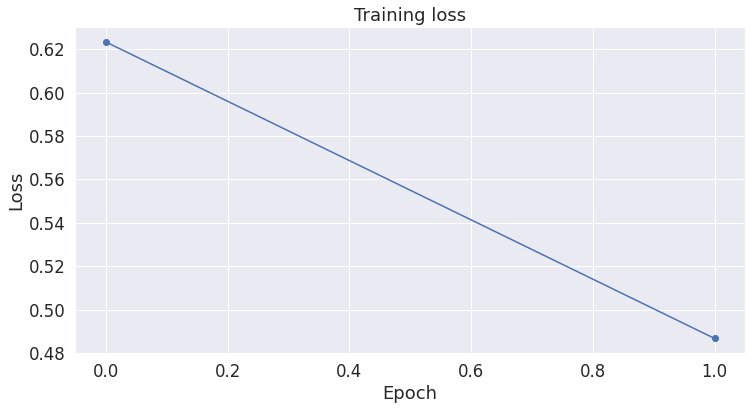

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

####Test

In [ ]:
test_sentences = test_comments.content.values
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]
test_labels = test_comments.label.values

In [ ]:
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]

In [ ]:
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_texts]
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask) 


test_torch_inputs = torch.tensor(test_input_ids)
test_torch_masks = torch.tensor(test_attention_masks)
test_torch_labels = torch.tensor(test_labels)

In [ ]:
# Set the batch size.  
batch_size = 16

# Create the DataLoader.
test_data = TensorDataset(test_torch_inputs, test_torch_masks, test_torch_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,393 test sentences...
    DONE.


In [ ]:
predictions[0:2], true_labels[0:2]


([array([[-0.9050137 ,  0.05865517],
         [-1.0472795 ,  0.66589856],
         [-1.7874372 ,  0.98536813],
         [-1.9798223 ,  1.4649936 ],
         [-1.0672196 ,  0.2787698 ],
         [ 0.16578327, -0.4780029 ],
         [-1.2077105 ,  1.3492777 ],
         [-0.9203272 ,  0.20260511],
         [ 0.11168532, -0.49797073],
         [-0.11480913, -0.14784801],
         [-0.20694253, -0.50588167],
         [-0.9549695 , -0.12048794],
         [ 0.21067615, -0.89807725],
         [-0.5562192 ,  0.1779208 ],
         [-0.90456915,  0.6307541 ],
         [ 0.7447971 , -1.3604826 ]], dtype=float32),
  array([[-1.0236938 ,  0.5913998 ],
         [-0.5160821 , -0.3093331 ],
         [ 0.5848424 , -0.66536045],
         [-1.1959656 ,  0.32952487],
         [-0.5796529 ,  0.85560036],
         [-1.0913582 ,  0.53249776],
         [-0.38889483, -0.32679823],
         [-1.6005837 ,  1.1853594 ],
         [-1.037938  ,  0.07108871],
         [ 0.21761648, -0.69726676],
         [-1.2476505 

In [ ]:
predictions[0][0][0]

-0.9050137

In [ ]:
count = 0
for batch_pred, batch_true in zip(predictions, true_labels):
  for idx, pred_prob in enumerate(batch_pred):
    if pred_prob[0] < pred_prob[1]:
      if batch_true[idx] == 1:
        count += 1
    if pred_prob[0] > pred_prob[1]:
      if batch_true[idx] == 0:
        count += 1
print('Accuracy: %.2f%%' % ((count / (Counter(test_comments['label'])[0] + Counter(test_comments['label'])[1]) * 100.0)))


Accuracy: 70.42%


In [ ]:
Counter(test_comments['label'])[0]

711

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (Counter(test_comments['label'])[1], 
                                               Counter(test_comments['label'])[0] + Counter(test_comments['label'])[1], 
                                               (Counter(test_comments['label'])[1] / (Counter(test_comments['label'])[0] + Counter(test_comments['label'])[1]) * 100.0)))

Positive samples: 682 of 1393 (48.96%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
matthews_set

[0.0,
 0.2,
 0.8563488385776753,
 0.49265895172303803,
 0.3779644730092272,
 0.5163977794943222,
 0.5163977794943222,
 0.5163977794943222,
 0.13483997249264842,
 0.4472135954999579,
 0.5163977794943222,
 0.49206349206349204,
 0.4666666666666667,
 0.5163977794943222,
 0.2581988897471611,
 0.42289003161103106,
 0.746031746031746,
 0.3333333333333333,
 0.5606119105813882,
 0.0,
 0.3133397807202561,
 0.06666666666666667,
 0.49265895172303803,
 0.6,
 0.5163977794943222,
 0.42289003161103106,
 0.629940788348712,
 0.42289003161103106,
 0.23809523809523808,
 0.25,
 0.5163977794943222,
 0.5238095238095238,
 0.6180700462007377,
 0.75,
 0.3779644730092272,
 0.5773502691896258,
 0.5,
 0.49265895172303803,
 0.3133397807202561,
 0.32277655457716287,
 0.49265895172303803,
 0.09759000729485331,
 0.5163977794943222,
 0.15289415743128767,
 0.21821789023599236,
 0.1259881576697424,
 0.2886751345948129,
 0.8819171036881969,
 0.75,
 0.3333333333333333,
 1.0,
 0.09759000729485331,
 0.6180700462007377,
 0.65

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.408


The performance of BERT model is better than LSTM. A preliminary trainiing could reach accuracy of over 70% on test set and a mattews correlation of 0.408. If we increase batch size and epochs, we may reach higher accuracy. So combining with other sources of information, the bert model could be used for movie recommendations. 

## Embeddings, Context Words

We saw how a bootstrapped BERT model performed so much better than a model trained from scatch. Because BERT's method of capturing context is bidirectional, meaning that words can now have different word embedding values based on their location within a sentence. Let us use the same BERT model to capture sentence and word embeddings. 

In [146]:
from transformers import BertModel

Let's go through the sentence format for the BERT model, as well as how our vocabulary looks like. Note that you have to use the BERT tokenizer to use the BERT model because of the similar vocabulary.

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

In [37]:
text = "随便"
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', '随', '便', '[SEP]']


BERTS model uses a WordPiece technique to do its tokenizing, as described in the paper. That's why the word embedding is split up the way it is.
A quick peek at what the voabulary looks like:

In [38]:
list(tokenizer.vocab.keys())[6000:6030]

['虧',
 '虫',
 '虬',
 '虱',
 '虹',
 '虻',
 '虽',
 '虾',
 '蚀',
 '蚁',
 '蚂',
 '蚊',
 '蚌',
 '蚓',
 '蚕',
 '蚜',
 '蚝',
 '蚣',
 '蚤',
 '蚩',
 '蚪',
 '蚯',
 '蚱',
 '蚵',
 '蛀',
 '蛆',
 '蛇',
 '蛊',
 '蛋',
 '蛎']

In [39]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "随便一句话."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
随             7,390
便               912
一               671
句             1,368
话             6,413
.               119
[SEP]           102


### Segment ID

BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence.

If you want to process two sentences, assign each word in the first sentence plus the ‘[SEP]’ token a 0, and all tokens of the second sentence a 1.

In [40]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1]


Like we did for classification, we now convert these segments to tensors.

The embedding layer is the hidden state layer, and this is what we pick up.

In [41]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [43]:
# Load pre-trained model (weights)
model_embedding = BertModel.from_pretrained('bert-base-chinese')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [44]:
output = model_embedding(tokens_tensor)

In [50]:
output

(tensor([[[-0.6407,  0.3427, -0.6734,  ...,  0.4961,  0.3978, -0.0321],
          [-0.5067, -0.2652,  0.2309,  ..., -0.7299, -0.3589,  0.3346],
          [ 0.3539, -1.0115, -1.2960,  ...,  0.7312,  0.4710,  0.2110],
          ...,
          [-0.6215, -0.7353,  0.0473,  ..., -0.3422,  1.5591,  0.1942],
          [ 0.1527, -0.1806, -0.1403,  ..., -0.6662,  0.4605, -0.0930],
          [-0.6084,  0.2465,  0.2648,  ...,  0.1502,  0.4991, -0.0156]]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[ 0.9941,  1.0000,  0.7028,  0.9277,  0.6990,  0.9353, -0.9162, -0.7413,
           0.9981, -0.9032,  1.0000, -0.3224, -0.7390, -0.9974,  0.9998, -0.9976,
          -0.8621,  0.9998,  0.9956,  0.0472,  0.9999, -1.0000, -0.9950,  0.7555,
           0.3969,  0.9589,  0.8862, -0.2226, -1.0000,  0.9400,  0.9346,  0.9937,
           0.8166, -1.0000, -0.9645,  0.8251, -0.6644,  0.9881, -0.9524, -0.9896,
          -0.8905, -0.4268,  0.6723, -0.7531, -0.9921,  0.1339, -1.0000, -0.9997,
           0.7

In [49]:
output.shape

AttributeError: ignored

In [45]:
output[0]

tensor([[[-0.6407,  0.3427, -0.6734,  ...,  0.4961,  0.3978, -0.0321],
         [-0.5067, -0.2652,  0.2309,  ..., -0.7299, -0.3589,  0.3346],
         [ 0.3539, -1.0115, -1.2960,  ...,  0.7312,  0.4710,  0.2110],
         ...,
         [-0.6215, -0.7353,  0.0473,  ..., -0.3422,  1.5591,  0.1942],
         [ 0.1527, -0.1806, -0.1403,  ..., -0.6662,  0.4605, -0.0930],
         [-0.6084,  0.2465,  0.2648,  ...,  0.1502,  0.4991, -0.0156]]],
       grad_fn=<NativeLayerNormBackward0>)

In [47]:
len(output[0][0][0]), len(output[1][0]) # the latter one: perhaps is the first sentence embedding

(768, 768)

### Understanding the Output

This kind of forward pass returns us the last layer of the net, which we will use to make our vectors. The first object returned contains the batch number, followed by each of the tokens and their vector values. The second object contains a vector value, which I suspect is the sentence vector of the tokens. 

The first index is the batch size, and our batch size is 1, so we just choose the 0th index and work with that.

In [ ]:
word_embeddings, sentence_embedding = output

In [ ]:
len(word_embeddings[0])

22

In [ ]:
word_embeddings[0]

tensor([[-0.4964, -0.1831, -0.5231,  ..., -0.1902,  0.3738,  0.3964],
        [-0.1323, -0.2762, -0.3495,  ..., -0.4567,  0.3786, -0.1096],
        [-0.3626, -0.4002,  0.0676,  ..., -0.3207, -0.2709, -0.3004],
        ...,
        [ 0.2961, -0.2856, -0.0382,  ..., -0.6056, -0.5163,  0.2005],
        [ 0.4878, -0.0909, -0.2358,  ..., -0.0017, -0.5945, -0.2431],
        [-0.2517, -0.3519, -0.4688,  ...,  0.2500,  0.0336, -0.2627]],
       grad_fn=<SelectBackward0>)

Let’s take a quick look at the range of values for a given layer and token.

You’ll find that the range is fairly similar for all layers and tokens, with the majority of values falling between [-2, 2], and a small smattering of values around -10.

In [ ]:
vec = word_embeddings[0][0] # the first batch, the first sentence( in this case 22 words), the first word 
vec = vec.detach().numpy()
len(vec)

768

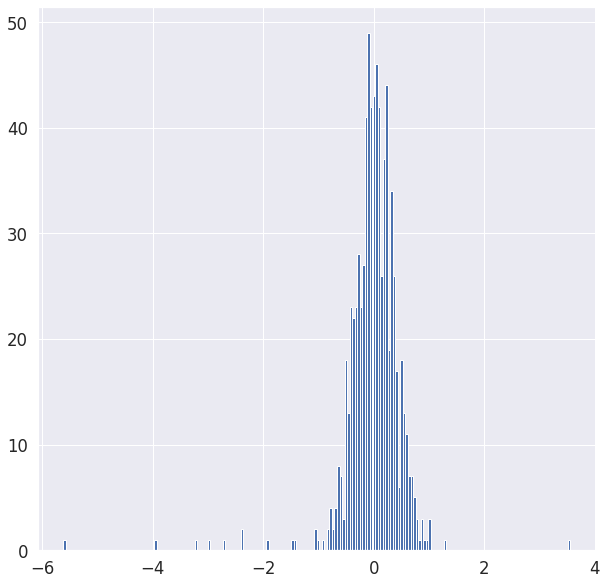

In [ ]:

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

These values are grouped by layer - we can use the permute function to make it grouped by each individual token instead. Let us look at what the later looks like:

### Word Vectors

So each of those tokens have embedding values - let us try and compare them with each other.

In [ ]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [ ]:
len(token_vecs)

22

Another method to create the vectors is to sum the last four layers.

### Sentence Vector

To get a single vector for our entire sentence we have multiple application-dependent strategies - we could just average all the tokens in our sentence. We can also use this oppurtunity to see if the second vector returned is a sentence vector too.

In [ ]:
sentence_embedding_0 = sentence_embedding.detach().numpy()[0]

In [ ]:
sentence_embedding_1 = np.mean(token_vecs, axis=0)

In [ ]:
len(sentence_embedding_0), len(sentence_embedding_1)

(768, 768)

Remember that the power of these vectors is how they are context dependant - our sentence had multiple uses of the word bank. Let us see the index and the word of the sentence and check the context accordingly. We'll then print the simlarity values for the similar and different meanings and see how it turns out.

In [ ]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs[6][:5]))
print("bank robber  ", str(token_vecs[10][:5]))
print("river bank   ", str(token_vecs[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    [ 0.90010506 -0.53804064 -0.16690865  0.22416212  0.6896582 ]
bank robber   [ 0.7977125  -0.52172714 -0.19836965  0.18898542  0.5940929 ]
river bank    [ 0.29608953 -0.28563383 -0.03818327  0.16736215  0.7712634 ]


In [ ]:
from scipy.spatial.distance import cosine


In [ ]:
# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs[10], token_vecs[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs[10], token_vecs[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.95
Vector similarity for *different* meanings:  0.70


This makes sense! Let us see if the mean value of all the tokens and what we think is the sentence vector is the same thing, by checking their cosine distance.

In [ ]:
1 - cosine(sentence_embedding_0, sentence_embedding_1)

0.008313165977597237

That is good - it seems it is indeed the sentence vector, so we can now write two functions which calculate the word and sentence vectors.

In [93]:
# def word_vector(text, word_id, model, tokenizer):
#     marked_text = "[CLS] " + text + " [SEP]"
#     tokenized_text = tokenizer.tokenize(marked_text)
#     indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#     tokens_tensor = torch.tensor([indexed_tokens])
#     word_embeddings, sentence_embeddings = model(tokens_tensor)   
#     vector = word_embeddings[0][word_id].detach().numpy()
#     return vector

def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings = model(tokens_tensor)
    sentence_embeddings = model(tokens_tensor)[1]
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [ ]:
word_10 = word_vector(text, 6, model_embedding, tokenizer)
word_6 = word_vector(text, 10, model_embedding, tokenizer)
word_19 = word_vector(text, 19, model_embedding, tokenizer)

In [92]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings = model(tokens_tensor)[0]
    sentence_embeddings = model(tokens_tensor)[1]
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    # do something
    return sentence_embedding

In [ ]:
sen_vec_0 = sentence_vector(text, model_embedding, tokenizer)
sen_vec_1 = sentence_vector(text, model_embedding, tokenizer, method="model")

### Similarity metrics
It is worth noting that word-level similarity comparisons are not appropriate with BERT embeddings because these embeddings are contextually dependent, meaning that the word vector changes depending on the sentence it appears in. This enables direct sensitivity to polysemy so that, e.g., your representation encodes river “bank” and not a financial institution “bank”. Nevertheless, it makes direct word-to-word similarity comparisons less valuable. For sentence embeddings, however, similarity comparison is still valid such that one can query, for example, a single sentence against a dataset of other sentences in order to find the most similar. Depending on the similarity metric used, the resulting similarity values will be less informative than the relative ranking of similarity outputs as some similarity metrics make assumptions about the vector space (equally-weighted dimensions, for example) that do not hold for our 768-dimensional vector space.

### Using the Vectors

Without fine-tuning, BERT features may be less useful than plain GloVe or word2vec.
They start to be interesting when you fine-tune a classifier on top of BERT. 

<!---
### Using Transformers Pipelines

The context vectors make the other pipeline functions which transformers has built in a lot more powerful. 

### NOTE
The pipeline functionality in transformers is currently being worked on and might be broken, so it is an optional part of the exercise. Do try to uncomment the lines of code and try to see if it works, though! If you have managed to get transformers v2.5.1 installed, it will work - I managed to get it to work sometimes, it can be annoying to get it to work but when it works it works well.

Consider the following:
--->

### BERT Sentence Perplexity

BERT can be used as a language model to see how "likely" a sentence is in that language model's configurations. This is the core technique used in one of our course readings, P. Vicinanza, A. Goldberg, S. Srivastava. 2020. “[Who Sees the Future? A Deep Learning Language Model  Demonstrates the Vision Advantage of Being Small](https://osf.io/preprints/socarxiv/j24pw/)”. 

Here is some additional reading on the topic. As the use of deep learning in social science grows, perplexity may be a particularly promising metric for high-quality research projects!

- [Can We Use BERT as a Language Model to Assign a Score to a Sentence?](https://www.scribendi.ai/can-we-use-bert-as-a-language-model-to-assign-score-of-a-sentence/)

- [Comparing BERT and GPT-2 as Language Models to Score the Grammatical Correctness of a Sentence](https://www.scribendi.ai/comparing-bert-and-gpt-2-as-language-models-to-score-the-grammatical-correctness-of-a-sentence/)

- [Transformers - Perplexity of fixed-length models](https://huggingface.co/transformers/perplexity.html)

- [Understanding evaluation metrics for language models](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/)

In [ ]:
import math

In [ ]:
from transformers import BertTokenizer,BertForMaskedLM

In [ ]:
bertMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def get_score(sentence, model, tokenizer):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    predictions = model(tensor_input)
    # print(predictions[0])
    # sentence_embedding, word_embedding = predictions[0], predictions[1]
    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(predictions[0].squeeze(),tensor_input.squeeze()).data 
    return math.exp(loss)

In [ ]:
get_score("Can you get some bread?", bertMaskedLM, tokenizer)

74.85005966246081

In [ ]:
get_score("This is a correct sentence.", bertMaskedLM, tokenizer)

59.18628880694981

In [ ]:
get_score("Fungus skatebutter", bertMaskedLM, tokenizer)

4150.436783869082

In [ ]:
get_score("Xuusgs ddd", bertMaskedLM, tokenizer)

214.5981611666885

A lower perplexity score suggests a sentence with a higher probability of being correct.

### Contextual Sentence Embeddings

Standard BERT sentence embeddings don't perform as well as special architectures built for sentence embeddings, such as BERT siamese networks. 

We will use the [UKPLab package "sentence transformers"](https://github.com/UKPLab/sentence-transformers
), which implement such methods.

- Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks (EMNLP 2019)
- Making Monolingual Sentence Embeddings Multilingual using Knowledge Distillation (EMNLP 2020)
- Augmented SBERT: Data Augmentation Method for Improving Bi-Encoders for Pairwise Sentence Scoring Tasks (NAACL 2021)
- The Curse of Dense Low-Dimensional Information Retrieval for Large Index Sizes (arXiv 2020)

Documentation for [SBERT](https://www.sbert.net/examples/applications/computing-embeddings/README.html).



In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 5.4 MB/s 
     |████████████████████████████████| 3.5 MB 15.9 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 596 kB 54.8 MB/s 
     |████████████████████████████████| 6.8 MB 59.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=28dc292dd31322e01a3844bdb6c5dee68e0e00facf058a0ae74e2c53a763c494
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.0.11
    Uninstalling tokenizers-0.0.11:
      Successfully uninstalled tokenizers-0.0.11
  Attempting uninstall: transformers
    Found existing installat

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']

In [ ]:
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

In [ ]:
#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

We recommend visiting the documentation to view other uses of these sentence embeddings, such as [clustering](https://www.sbert.net/examples/applications/clustering/README.html), [Paraphrase Mining](https://www.sbert.net/examples/applications/paraphrase-mining/README.html), [Semantic Search](https://www.sbert.net/examples/applications/semantic-search/README.html), [Retreive and Rank](https://www.sbert.net/examples/applications/retrieve_rerank/README.html), and even multi-modal [Image Search](https://www.sbert.net/examples/applications/image-search/README.html).

## BERTology

"BERTology" refers to the growing number of papers disecting BERT and it's inner workings. 

- [A Primer in BERTology: What we know about how BERT works](https://arxiv.org/abs/2002.12327)

- [Huggingface Transformers page on BERTology](https://huggingface.co/transformers/bertology.html)

### Visualizing BERT Attention

Just as we visualized our seq2seq attention, we can also visualize the tttention layers to understand BERT.

**We highly recommend this visual blog on [explaining Transformers](http://jalammar.github.io/explaining-transformers/
) and this visual blog on [visualising hidden states](http://jalammar.github.io/hidden-states/
) before proceeding**

The package "bertviz" [(GitHub link)](https://github.com/jessevig/bertviz) allows us to look into specific layers of multiple Transformers based models. 

This [blog post](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1) walks through the architecture of BERT and what exactly we can visualise. If you intend on using the BERT visualisations we recommend going through the blog post.

We also point these two other visualisations tools for such models:
- [Seq2Seq-Vis](http://seq2seq-vis.io/), [GitHub link](https://github.com/HendrikStrobelt/Seq2Seq-Vis)
- [exBERT](https://exbert.net/), [GitHub link](https://github.com/bhoov/exbert)


In [154]:
!pip install bertviz

     |████████████████████████████████| 155 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 45.1 MB/s 


In [155]:
# Load model and retrieve attention weights

from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

In [ ]:
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)

In [ ]:
inputs

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[  101,  1996,  4937,  2938,  2006,  1996, 13523,   102,  1996,  4937,
           3913,  2006,  1996, 20452,   102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1) # the beginning of b sentence 
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [1]:
token_type_ids

NameError: ignored

## Model View
The model view gives a birds-eye view of attention across all of the layers (rows) and heads (columns) in the model. In this case we are showing *bert-base*, which has 12 layers and 12 heads (zero-indexed). 

### Usage
* **Click** on any **cell** for a detailed view of attention for the associated attention head.
* Then **hover** over any **token** on the left side of detail view to filter the attention from that token.
* The lines show the attention from each token (left) to every other token (right). Darker lines indicate higher attention weights.  

In [ ]:
model_view(attention, tokens, sentence_b_start)

Output hidden; open in https://colab.research.google.com to view.

## Head View
The attention-head view visualizes attention in one or more heads in a particular layer in the model.

### Usage
* **Hover** over any **token** on the left/right side of the visualization to filter attention from/to that token. The colors correspond to different attention heads.
* **Double-click** on any of the **colored tiles** at the top to filter to the corresponding attention head.
* **Single-click** on any of the **colored tiles** to toggle selection of the corresponding attention head. 
* **Click** on the **Layer** drop-down to change the model layer (zero-indexed).
* The lines show the attention from each token (left) to every other token (right). Darker lines indicate higher attention weights. When multiple heads are selected, the attention weights are overlaid on one another. 

In [ ]:
head_view(attention, tokens, sentence_b_start)

Output hidden; open in https://colab.research.google.com to view.

## Neuron View
The attention-head view visualizes attention, as well as query and key values, in a particuler attention head.

**NOTE: This visualization requires Chrome when run in Colab**

### Usage
* **Hover** over any of the tokens on the left side of the visualization to filter attention from that token.
* Then **click** on the **plus** icon that is revealed when hovering. This shows the query vectors, key vectors, and intermediate computations for the attention weights (<span style='color:blue'>blue</font>=positive, <span style='color:#ff6318'>orange</font>=negative).  
* Once in the expanded view, **hover** over any other **token** on the left to see the associated attention computations.
* **Click** on the **Layer** or **Head** drop-downs to change the model layer or head (zero-indexed).

In [ ]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

In [ ]:
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
model_type = 'bert'
show(model, model_type, tokenizer, sentence_a, sentence_b, layer=2, head=0)

Output hidden; open in https://colab.research.google.com to view.

These visualisations essentially allow us to see what attention values are assigned between a pair of sentences within the BERT model. 

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that visualize your BERT model with the `bertviz` package.

In [147]:
model_version = '/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_batch16_epoch2'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "电影太烂了" # This is really a bad movie! 
sentence_b = "我给这个电影打负五星。" # I give the movie a negative five. 

Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_batch16_epoch2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [148]:
inputs = tokenizer.encode_plus(sentence_a, sentence_b, add_special_tokens=True)

In [149]:
inputs['attention_mask'] = torch.tensor(inputs['attention_mask']).unsqueeze(0)
inputs['input_ids'] = torch.tensor(inputs['input_ids']).unsqueeze(0)
inputs['token_type_ids'] = torch.tensor(inputs['token_type_ids']).unsqueeze(0)

In [150]:
inputs['input_ids']

tensor([[ 101, 4510, 2512, 1922, 4162,  749,  102, 2769, 5314, 6821,  702, 4510,
         2512, 2802, 6566,  758, 3215,  511,  102]])

In [151]:
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1) # the beginning of b sentence 
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [157]:
model_view(attention, tokens, sentence_b_start)

Output hidden; open in https://colab.research.google.com to view.

In [158]:
head_view(attention, tokens, sentence_b_start)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
model_type = 'bert'
show(model, model_type, tokenizer, sentence_a, sentence_b, layer=2, head=0)

Output hidden; open in https://colab.research.google.com to view.

Contextual models can also help us visualize how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [9]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [12]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [15]:
text = "Do you have your chips with fish or with salsa?" 

In [16]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [17]:
import seaborn as sns

In [89]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings = model(tokens_tensor)
    sentence_embeddings = model(tokens_tensor)[1]
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [90]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        print(i)
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [91]:
visualise_diffs(text, roberta_us_model_embedding, roberta_us_tokenizer)

0
1


IndexError: ignored

In [ ]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

In [ ]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

What do you see regarding the relations with chips and sala/fish? What about the other sentences? How about comparing sentence embeddings?

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

**I spent a lot of time doing this task and tried to figure out what's wrong with the functions given above. I found out that the ouput layer of our fine-tuned model only returns the vectors of the classified results, not the 768dim vectors of the sentences. So it's not feasible to compare using outputs from different fine-tuned models.**

In this exercise I'll fine tune another BERT model using movie comments from another website www.maoyan.com. This website is more commercial, a lot of people buy movie tickets on this website and leave comments. So this website has many popular box movie comments. On the other hand, movie.douban.com is more focused on comments, discussion, and recommendation. For a same movie, the rating on maoyan.com is very likely to be higher than rating on movie.douban.com. It's long been argued that these two websites have different target customer groups.(datasource: https://github.com/tss12/movieComments)

I will also use another fine tuned bert model trained by other people(from Tencent) using comments from dianping(https://m.dianping.com/), a chinese version yelp. (model from: https://huggingface.co/uer/roberta-base-finetuned-dianping-chinese)

###BERT model trained on maoyan data

####data preprocessing

In [18]:
maoyanDF = pd.read_csv('/content/drive/MyDrive/Dataset/maoyan_movieComments.csv',names=['ID','Location','Content','Rating','Comment_time'], header=None,encoding='gbk')
maoyanDF = maoyanDF[['Comment_time', 'Rating', 'Content']][:10000].rename(columns={'Comment_time': 'comment_time',
                                                                   'Rating': 'rating',
                                                                   'Content':'content'})
maoyanDF

,comment_time,rating,content
0,2019-02-17 12:26:01,4.5,吹爆这部电影，二刷了。第一次3d，这次imax。果然还是imax效果好，能看imax就别看3...
1,2019-02-17 12:25:52,3.0,还可以吧??
2,2019-02-17 12:25:47,5.0,?中国电影加油！期待超越！
3,2019-02-17 12:25:44,5.0,另一个朋友请我看了，觉得好看，我给朋友买的，她们没去看。浪费两张票
4,2019-02-17 12:25:35,5.0,特效完美，电影令人深思
...,...,...,...
9995,2019-02-09 23:28:14,5.0,特效棒棒的哦
9996,2019-02-09 23:28:04,5.0,很好看，中国的科幻片不输好莱坞大片
9997,2019-02-09 23:28:03,5.0,为中国科幻电影点赞
9998,2019-02-09 23:28:02,5.0,很好看的中国科幻电影 为中国制造加油


In [19]:
from collections import Counter
Counter(maoyanDF['rating'])

Counter({0.0: 10,
         0.5: 280,
         1.0: 39,
         1.5: 60,
         2.0: 49,
         2.5: 211,
         3.0: 147,
         3.5: 287,
         4.0: 602,
         4.5: 1524,
         5.0: 6787,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1})

We can even find the difference between the two websites now. There're far less unrated movie comments on maoyan. And there is a preponderance of people rated 5.0(But the truth is that all these comments are from a good movie 流浪地球（The Wandering Earth）. To make the dataset not so unbalanced, we set the criteria for 'good' as 5.0

In [22]:
def get_labels(x):
  if x in set((0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5)):
    return 0
  elif x == 5.0:
    return 1 
  else:
    return -1

maoyanDF['label'] = maoyanDF['rating'].apply(get_labels)
maoyanDF.head(10)

,comment_time,rating,content,label
0,2019-02-17 12:26:01,4.5,吹爆这部电影，二刷了。第一次3d，这次imax。果然还是imax效果好，能看imax就别看3...,0
1,2019-02-17 12:25:52,3.0,还可以吧??,0
2,2019-02-17 12:25:47,5.0,?中国电影加油！期待超越！,1
3,2019-02-17 12:25:44,5.0,另一个朋友请我看了，觉得好看，我给朋友买的，她们没去看。浪费两张票,1
4,2019-02-17 12:25:35,5.0,特效完美，电影令人深思,1
5,2019-02-17 12:25:33,5.0,很好看，点赞！！！！！,1
6,2019-02-17 12:25:31,4.5,高质量的科幻电影，打9分，优点不再赘述，场面、故事都非常好。说点自己认为不好的：一是感情戏太...,0
7,2019-02-17 12:25:28,5.0,好看，中国科幻电影有希望了,1
8,2019-02-17 12:25:23,4.0,还不错，值得看,0
9,2019-02-17 12:25:15,4.5,很不错，虽然觉得个别角色的话太多，情节中也有些为了搞笑而故作搞笑，但不失为一部顶级的科幻电影...,0


In [24]:
train_test_comments = maoyanDF[maoyanDF['label'] != -1].reset_index(drop=True)

In [25]:
train_idx, test_idx = train_test_split(train_test_comments.index, test_size=0.3, random_state=42)

In [26]:
train_comments = train_test_comments.iloc[train_idx, :]
Counter(train_comments['label'])

Counter({0: 2246, 1: 4751})

In [27]:
test_comments = train_test_comments.iloc[test_idx, :]
Counter(test_comments['label'])

Counter({0: 963, 1: 2036})

In [28]:
sentences = train_comments.content.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = train_comments.label.values

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', '垃', '圾', '片', '，', '不', '知', '道', '演', '什', '么', '[SEP]']


In [30]:
MAX_LEN = 128

In [31]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [32]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.1)

####Training&Testing

In [33]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [34]:
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [35]:
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [36]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [37]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

In [38]:
from transformers import get_linear_schedule_with_warmup

epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

####Original Pytorch Training

In [39]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch    40  of    394.    Elapsed: 0:00:09.
  Batch    80  of    394.    Elapsed: 0:00:18.
  Batch   120  of    394.    Elapsed: 0:00:27.
  Batch   160  of    394.    Elapsed: 0:00:36.
  Batch   200  of    394.    Elapsed: 0:00:46.
  Batch   240  of    394.    Elapsed: 0:00:55.
  Batch   280  of    394.    Elapsed: 0:01:04.
  Batch   320  of    394.    Elapsed: 0:01:13.
  Batch   360  of    394.    Elapsed: 0:01:22.

  Average training loss: 0.51
  Training epcoh took: 0:01:29

Running Validation...
  Accuracy: 0.79
  Validation took: 0:00:03

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    394.    Elapsed: 0:00:09.
  Batch    80  of    394.    Elapsed: 0:00:18.
  Batch   120  of    394.    Elapsed: 0:00:27.
  Batch   160  of    394.    Elapsed: 0:00:36.
  Batch   200  of    394.    Elapsed: 0:00:45.
  Batch   240  of    394.    Elapsed: 0:00:54.
  Batch   280  of    394.    Elapsed: 0:01:03.
  Batch   320  of    394.    Elapsed: 0:01:13.
  Batch   360  of    394.    

####Save model

In [40]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_maoyan_batch16_epoch2/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_maoyan_batch16_epoch2/


('/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_maoyan_batch16_epoch2/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_maoyan_batch16_epoch2/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_maoyan_batch16_epoch2/added_tokens.json')

####PLOT

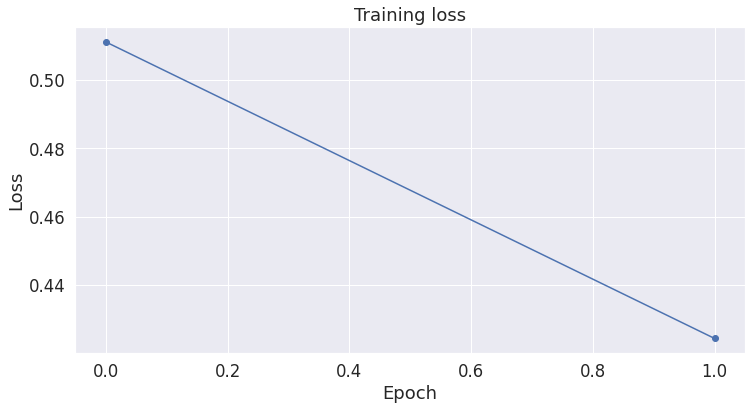

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

####Test

In [43]:
test_sentences = test_comments.content.values
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]
test_labels = test_comments.label.values

In [44]:
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]

In [45]:
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_texts]
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

test_attention_masks = []

for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

In [46]:
test_torch_inputs = torch.tensor(test_input_ids)
test_torch_masks = torch.tensor(test_attention_masks)
test_torch_labels = torch.tensor(test_labels)

In [47]:
# Set the batch size.  
batch_size = 16

# Create the DataLoader.
test_data = TensorDataset(test_torch_inputs, test_torch_masks, test_torch_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [48]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,999 test sentences...
    DONE.


In [50]:
count = 0
for batch_pred, batch_true in zip(predictions, true_labels):
  for idx, pred_prob in enumerate(batch_pred):
    if pred_prob[0] < pred_prob[1]:
      if batch_true[idx] == 1:
        count += 1
    if pred_prob[0] > pred_prob[1]:
      if batch_true[idx] == 0:
        count += 1
print('Accuracy: %.2f%%' % ((count / (Counter(test_comments['label'])[0] + Counter(test_comments['label'])[1]) * 100.0)))

Accuracy: 79.13%


In [51]:
Counter(test_comments['label'])[0]

963

In [52]:
print('Positive samples: %d of %d (%.2f%%)' % (Counter(test_comments['label'])[1], 
                                               Counter(test_comments['label'])[0] + Counter(test_comments['label'])[1], 
                                               (Counter(test_comments['label'])[1] / (Counter(test_comments['label'])[0] + Counter(test_comments['label'])[1]) * 100.0)))

Positive samples: 2036 of 2999 (67.89%)


In [53]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [54]:
matthews_set

[0.363696483726654,
 0.5447047794019222,
 0.0,
 0.6546536707079772,
 0.7867957924694432,
 0.8563488385776753,
 0.6666666666666666,
 0.674199862463242,
 0.7090909090909091,
 1.0,
 0.07273929674533079,
 0.4472135954999579,
 -0.0778498944161523,
 0.3133397807202561,
 0.30261376633440124,
 0.7125253031944253,
 0.8703882797784892,
 0.7453559924999299,
 0.8703882797784892,
 0.6666666666666666,
 0.8703882797784892,
 0.6546536707079772,
 0.674199862463242,
 0.15289415743128767,
 0.6546536707079771,
 0.8563488385776753,
 0.4622501635210242,
 0.7125253031944253,
 0.53748384988657,
 0.16012815380508713,
 -0.12403473458920847,
 0.28941438070815306,
 0.6666666666666666,
 0.40451991747794525,
 0.42289003161103106,
 1.0,
 0.6546536707079772,
 0.15289415743128767,
 0.6201736729460423,
 0.4879500364742666,
 -0.12403473458920847,
 0.07273929674533079,
 0.5222329678670935,
 0.5449492609130661,
 0.13483997249264842,
 0.5773502691896258,
 1.0,
 0.2219167619785609,
 0.3578300267477955,
 0.6201736729460423,


In [55]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.493


###BERT model trained on dianping data

In [11]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer,pipeline
model_dianping = AutoModelForSequenceClassification.from_pretrained('uer/roberta-base-finetuned-chinanews-chinese')
dianping_tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-chinanews-chinese')

Downloading:   0%|          | 0.00/880 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/390M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

###Comparison

In [53]:
model_douban = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_batch16_epoch2", num_labels=2)

In [54]:
douban_tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_batch16_epoch2")


In [11]:
model_maoyan = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_maoyan_batch16_epoch2", num_labels=2)


In [12]:
maoyan_tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_maoyan_batch16_epoch2")

In [55]:
model_douban.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [56]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [57]:
import seaborn as sns
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [58]:
text = '这电影不错'

In [59]:
visualise_diffs(text, model_douban, douban_tokenizer)

ValueError: ignored

In [73]:
text = "This is a sentence."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = roberta_us_tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[', 'CL', 'S', ']', 'ĠThis', 'Ġis', 'Ġa', 'Ġsentence', '.', 'Ġ[', 'SE', 'P', ']']


In [61]:
# indexed_tokens = douban_tokenizer.convert_tokens_to_ids(tokenized_text)
indexed_tokens = roberta_us_tokenizer.convert_tokens_to_ids(tokenized_text)
roberta_us_model_embedding


In [62]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1]


In [63]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [70]:
output = model_douban(tokens_tensor)

['__annotations__',
 '__class__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'attentions',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'logits',
 'loss',
 'move_to_end',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [69]:
output

SequenceClassifierOutput([('logits',
                           tensor([[ 0.5615, -1.2232]], grad_fn=<AddmmBackward0>))])

In [65]:
len(output[0][0][0]
    ), len(output[1][0])

TypeError: ignored

### Language Modeling with 'pipelines'
We will now use the popular Transformers package default 'pipelines' feature to do language modeling.
Language modeling is the task of fitting a model to a corpus, which can be domain specific. All popular
transformer-based models are trained using a variant of language modeling, e.g., BERT with masked language modeling,
GPT-2/3 with causal language modeling.

Language modeling can be useful beyond pretraining as well, for example to shift the model distribution to be
domain-specific: using a language model trained over a very large corpus, and then fine-tuning it to a news dataset or
on scientific papers e.g. [LysandreJik/arxiv-nlp](https://huggingface.co/lysandre/arxiv-nlp).

#### Masked Language Modeling

Masked language modeling is the task of masking tokens in a sequence with a masking token, and prompting the model to
fill that mask with an appropriate token. This allows the model to attend to both the right context (tokens on the
right of the mask) and the left context (tokens on the left of the mask). Such a training creates a strong basis for
downstream tasks requiring bi-directional context, such as SQuAD (question answering, see [Lewis, Lui, Goyal et al.](https://arxiv.org/abs/1910.13461), part 4.2).

Here is an example of using pipelines to replace a mask from a sequence:

In [74]:
from transformers import pipeline
nlp = pipeline("fill-mask")

No model was supplied, defaulted to distilroberta-base (https://huggingface.co/distilroberta-base)


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

This outputs the sequences with the mask filled, the confidence score, and the token id in the tokenizer vocabulary:

In [75]:
from pprint import pprint
pprint(nlp(f"HuggingFace is creating a {nlp.tokenizer.mask_token} that the community uses to solve NLP tasks."))

[{'score': 0.17927508056163788,
  'sequence': 'HuggingFace is creating a tool that the community uses to solve '
              'NLP tasks.',
  'token': 3944,
  'token_str': ' tool'},
 {'score': 0.11349432915449142,
  'sequence': 'HuggingFace is creating a framework that the community uses to '
              'solve NLP tasks.',
  'token': 7208,
  'token_str': ' framework'},
 {'score': 0.05243564024567604,
  'sequence': 'HuggingFace is creating a library that the community uses to '
              'solve NLP tasks.',
  'token': 5560,
  'token_str': ' library'},
 {'score': 0.034935563802719116,
  'sequence': 'HuggingFace is creating a database that the community uses to '
              'solve NLP tasks.',
  'token': 8503,
  'token_str': ' database'},
 {'score': 0.028602417558431625,
  'sequence': 'HuggingFace is creating a prototype that the community uses to '
              'solve NLP tasks.',
  'token': 17715,
  'token_str': ' prototype'}]


Here is an example of doing masked language modeling using a model and a tokenizer. The process as follows:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a DistilBERT model and
   loads it with the weights stored in the checkpoint.
2. Define a sequence with a masked token, placing the `tokenizer.mask_token` instead of a word.
3. Encode that sequence into a list of IDs and find the position of the masked token in that list.
4. Retrieve the predictions at the index of the mask token: this tensor has the same size as the vocabulary, and the
   values are the scores attributed to each token. The model gives higher scores to tokens it deems probable in that
   context.
5. Retrieve the top 5 tokens using the PyTorch `topk` or TensorFlow `top_k` methods.
6. Replace the mask token by the tokens and print the results

In [76]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
model = AutoModelWithLMHead.from_pretrained("distilbert-base-cased")
sequence = f"Distilled models are smaller than the models they mimic. Using them instead of the large versions would help {tokenizer.mask_token} our carbon footprint."
input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]
token_logits = model(input).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

This prints five sequences, with the top 5 tokens predicted by the model:

In [77]:
for token in top_5_tokens:
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

Distilled models are smaller than the models they mimic. Using them instead of the large versions would help reduce our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help increase our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help decrease our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help offset our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help improve our carbon footprint.


#### Causal Language Modeling

Causal language modeling is the task of predicting the token following a sequence of tokens. In this situation, the
model only attends to the left context (tokens on the left of the mask). Such a training is particularly interesting
for generation tasks.

Usually, the next token is predicted by sampling from the logits of the last hidden state the model produces from the
input sequence.

Here is an example of using the tokenizer and model and leveraging the
`PreTrainedModel.top_k_top_p_filtering` method to sample the next token following an input sequence
of tokens.

In [84]:
from transformers import AutoModelWithLMHead, AutoTokenizer, top_k_top_p_filtering
import torch
from torch.nn import functional as F
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelWithLMHead.from_pretrained("gpt2")
sequence = f"Hugging Face is based in DUMBO, New York City, and "
input_ids = tokenizer.encode(sequence, return_tensors="pt")


In [85]:
# get logits of last hidden state
print(len(model(input_ids)[0][0][0]))
next_token_logits = model(input_ids).logits[:, -1, :]
print(len(next_token_logits[0]))
# filter
filtered_next_token_logits = top_k_top_p_filtering(next_token_logits, top_k=50, top_p=1.0)
# sample
probs = F.softmax(filtered_next_token_logits, dim=-1)
next_token = torch.multinomial(probs, num_samples=1)
generated = torch.cat([input_ids, next_token], dim=-1)
resulting_string = tokenizer.decode(generated.tolist()[0])

50257
50257


This outputs a (hopefully) coherent next token following the original sequence, which in our case is the word **has**:

In [86]:
print(resulting_string)

Hugging Face is based in DUMBO, New York City, and  


## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [94]:
model_douban = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_batch16_epoch2", num_labels=2)
douban_tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/week7_deep_learning/model_bert_batch16_epoch2")

In [95]:
text_classification = pipeline('sentiment-analysis', model=model_douban, tokenizer=douban_tokenizer)

In [96]:
text_classification("这个电影很烂") # this movie is very bad 

[{'label': 'LABEL_0', 'score': 0.9206787347793579}]

My hunch about comments on douban.com is that these sentiments become sentimentally polarized over time.Let's use bert to test it.

In [130]:
comments = pd.read_csv('/content/drive/MyDrive/Dataset/moviedata-10m/comments.csv')
comments = comments.loc[:, ['COMMENT_TIME','MOVIE_ID', 'RATING', 'CONTENT']][:100000].rename(columns={'COMMENT_TIME':'comment_time',
                                                                                                       'MOVIE_ID':'movie_id',
                                                                                                       'RATING':'rating',
                                                                                                       'CONTENT':'content'})
# comments = pd.read_csv('/content/drive/MyDrive/Dataset/moviedata_small/comments.csv')
# comments = comments.loc[:, ['comment_time','douban_id', 'rating', 'content']]

In [131]:
comments['comment_time'] = pd.to_datetime(comments['comment_time'])
comments = comments.set_index('comment_time').sort_index()
comments

,movie_id,rating,content
comment_time,,,
2005-07-03 18:40:48,1358424,3.0,2005文化大劇院
2005-07-03 23:25:48,1306466,5.0,2002 HKIFF
2005-07-05 11:41:28,1307290,3.0,小泉今日子
2005-07-06 01:43:44,1303585,3.0,"看的時候覺得有種""機動警察""的味道，那些警察一樣的懶洋洋。"
2005-07-10 05:39:12,1293203,1.0,現在一聽到那首主題曲就想死。令我更無法面對當時也曾看到流淚的事實。
...,...,...,...
2019-09-06 16:20:26,1306028,3.0,展现工人阶级愤怒青年横冲直撞的生活
2019-09-06 16:44:48,2281686,4.0,大预言太牛逼了，五星。把重点压在预言结束之后是多有想法，突然转向集体无意识让人猝不及防，既有...
2019-09-06 16:54:36,26329059,3.0,鸟枪换炮式的翻拍啊，原版就是一个小成本喜剧吧，演员也都不太行的感觉。


In [132]:
comments_count = comments['content'].groupby(comments.index.year)\
                                             .count()\
                                             .to_list()

In [133]:
comments_count

[63,
 533,
 1153,
 2781,
 4339,
 7307,
 10356,
 10670,
 8934,
 6857,
 6172,
 9208,
 11158,
 11948,
 8521]

In [134]:
dic = {}
year = 2005
for year_num in comments_count:
    dic[year] = year_num
    year+=1
dic

{2005: 63,
 2006: 533,
 2007: 1153,
 2008: 2781,
 2009: 4339,
 2010: 7307,
 2011: 10356,
 2012: 10670,
 2013: 8934,
 2014: 6857,
 2015: 6172,
 2016: 9208,
 2017: 11158,
 2018: 11948,
 2019: 8521}

In [135]:
sent = lambda x: text_classification(x)[0]

comments['sentiment'] = comments['content'].apply(sent)

In [136]:
def get_label(x):
  if x['label'] == 'LABEL_0':
    return 'NEGATIVE'
  else:
    return 'POSITIVE'

comments['label'] = comments['sentiment'].apply(get_label)
comments['score'] = comments['sentiment'].apply(lambda x: round(x['score'], 4))

In [137]:
def get_year_statistics(cur, year_num):
    
    label_arr = np.stack(comments['label'].iloc[cur: cur+year_num])
    score_arr = np.stack(comments['score'].iloc[cur: cur+year_num])
    pos_count = 0
    neg_count = 0
    pos_avg = 0
    neg_avg = 0
    
    for label, score in zip(label_arr, score_arr):
        if label == 'POSITIVE':
            pos_count += 1
            pos_avg += score
        else:
            neg_count += 1
            neg_avg += score
    
    pos_ratio = pos_count/year_num
    pos_avg = pos_avg/pos_count
    neg_avg = neg_avg/neg_count
    return [pos_count, neg_count, pos_ratio, pos_avg, neg_avg]

In [138]:
cur = 0
year = 2005
dic = {}
for year_num in comments_count:
    dic[year] = get_year_statistics(cur, year_num)
    year += 1
    cur += year_num

In [139]:
df = pd.DataFrame(dic)
trend = df.stack().unstack(0)

In [140]:
trend.columns = ['positive_count', 'negative_count', 'positive_ratio', 'positive_avg_score', 'negative_avg_score']

In [141]:
trend

,positive_count,negative_count,positive_ratio,positive_avg_score,negative_avg_score
2005,33.0,30.0,0.523810,0.762570,0.755777
2006,276.0,257.0,0.517824,0.764314,0.767319
2007,586.0,567.0,0.508239,0.769024,0.768462
2008,1365.0,1416.0,0.490831,0.778408,0.779019
2009,2068.0,2271.0,0.476608,0.779886,0.785471
2010,3649.0,3658.0,0.499384,0.779527,0.786412
2011,4969.0,5387.0,0.479818,0.779293,0.791204
2012,5124.0,5546.0,0.480225,0.778939,0.792250
2013,4091.0,4843.0,0.457914,0.776783,0.790878
2014,2951.0,3906.0,0.430363,0.772138,0.797309


Text(0.5, 1.0, 'Positive Contents Proportion(2005-2019)')

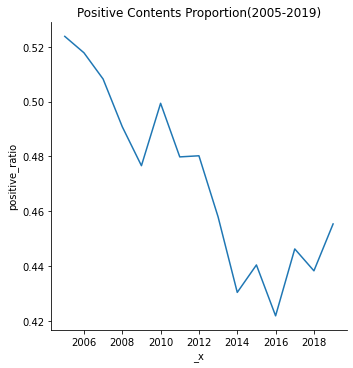

In [142]:
import seaborn as sns
years = trend.index
ratio = trend['positive_ratio']
sns.relplot(x = years, y = ratio, kind = 'line');
plt.title("Positive Contents Proportion(2005-2019)")

Text(0.5, 1.0, 'Average Positive Score (2005-2019)')

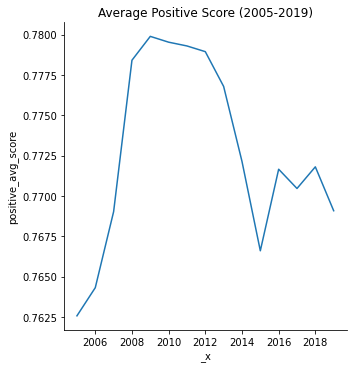

In [143]:
years = trend.index
pos_avg_score = trend['positive_avg_score']
sns.relplot(x = years, y = pos_avg_score, kind = 'line');
plt.title("Average Positive Score (2005-2019)")

Text(0.5, 1.0, 'Average Negative Score (2005-2019)')

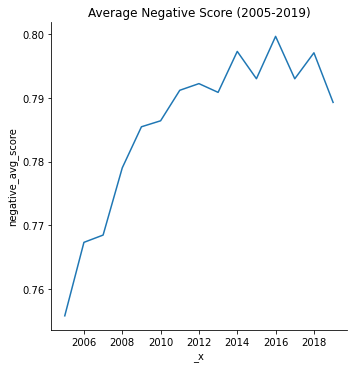

In [144]:
years = trend.index
neg_avg_score = trend['negative_avg_score']
sns.relplot(x = years, y = neg_avg_score, kind = 'line');
plt.title("Average Negative Score (2005-2019)")

My hunch is largely correct! The proprotion of positive comments dcreased overtime. The average possitve score didn't change much over time, but we can find that the average score of neagtive increased, which means we tend to express more nevative feelings in our movie comments. 